In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import numpy as np
sns.set_style("darkgrid")
from scipy import stats
import random
from scipy.stats import median_absolute_deviation

## Processing and Cleaning Data

In [20]:
import warnings
warnings.filterwarnings('ignore')

def clean(data):
    
    data.loc[191520:230640,'C0 Pulse Rate 1'] = data[data.Observation == 20]['C0 Pulse Rate']
    data.loc[348870:381423,'A1 PPG, X, PPGED-R'] = data[data.Observation == 3]['A2 PPG, X, PPGED-R']
    data.loc[348870:381423,'A13 EDA, Y, PPGED-R'] = data[data.Observation == 3]['A14 EDA, Y, PPGED-R']
    data.loc[348870:381423,'C0 Pulse Rate 1'] = data[data.Observation == 3]['C1 Pulse Rate 2']
    data.drop(['A14 EDA, Y, PPGED-R','A2 PPG, X, PPGED-R','C1 Pulse Rate 2','C0 Pulse Rate',
    'Date_Time_Absolute_dmy_hmsf', 'Date_dmy', 'Time_Absolute_hms',
    'Time_Absolute_f', 'Time_Relative_hmsf', 'Time_Relative_hms',
    'Time_Relative_f'],inplace=True,axis=1)
    data["A13 EDA, Y, PPGED-R"] = [float(x) for x in data["A13 EDA, Y, PPGED-R"]]
    data["A1 PPG, X, PPGED-R"] = [float(x) for x in data["A1 PPG, X, PPGED-R"]]

    
    selected_data = []

    for i in data["Behavior"]: #data.engagement
        if i in ["-5","5","0","1","2","-2","-1"]:
            selected_data.append(i)

    data = data[data.Behavior.isin(selected_data)]
    #data_new = data[data["Gaze point X"].isin(selected_data)]

    data = data[data['Action Unit 01 - Inner Brow Raiser '] != "-"]
    data = data[data["Behavior"] != "-5"]
    data = data.reset_index(drop=True) 

    return data

def get_action_units(data):
    action_units = []
    for i in data.columns:
        if i.startswith("Action") and i != "Action Unit 43 - Eyes Closed ":
            action_units.append(i)
    return action_units

def plot_dist(data,label):
    sns.set_style("darkgrid")
    fig,axes = plt.subplots(4,5, figsize=(30,15))
    axes = axes.ravel()

    for col, ax in zip(action_units, axes):
        sns.histplot(data[data.Behavior == str(label)][col],ax=ax,kde=True)

def preprocess(data):
    for i in action_units:
        data[i] = [float(x) for x in data[i]]

    return data

def plot_individual_dist(data,au,Behavior):
    plt.figure(figsize=(10,5))
    sns.distplot(data[Behavior == str(2)][action_units[au]],kde=True,label="2")
    sns.distplot(data[Behavior == str(1)][action_units[au]],kde=True,color="red",label="1")
    sns.distplot(data[Behavior == str(0)][action_units[au]],kde=True,color="black",label="0")
    sns.distplot(data[Behavior == str(-1)][action_units[au]],kde=True,color="orange",label="-1")
    sns.distplot(data[Behavior == str(-2)][action_units[au]],kde=True,color="purple",label="-2")
    plt.legend()

def preprocess_observer(data):
    data = data[data.annotation_3 != "x"]
    data["viewer_label"] = [round(i) for i in data.label]
    data["annotation_1"] = [int(i) for i in data.annotation_1]
    data["annotation_2"] = [int(i) for i in data.annotation_2]
    data["annotation_3"] = [int(i) for i in data.annotation_3]
    data["final_label"] = "None"
    
    for i,(j,k,l) in enumerate(zip(data.annotation_1,data.annotation_2,data.annotation_3)):
        if (j==k or j==l):
            data.final_label.iloc[i] = j
        if (k==j or k==l):
            data.final_label.iloc[i] = k
        if (l==j or l==k):
            data.final_label.iloc[i] = l

    data['engagement_num_final'] = 'None'

    for k,(i, j) in enumerate(zip(data.final_label,data.viewer_label)):
        if i == j:
            data.engagement_num_final.iloc[k] = i
    
    data["annotation_1_e"] = 0
    data["annotation_2_e"] = 0
    data["annotation_3_e"] = 0
    
    for i in range(0,data.shape[0]):
        if data.annotation_1.iloc[i] > 0:
            data.annotation_1_e.iloc[i] = "e"
        if data.annotation_1.iloc[i] < 0:
            data.annotation_1_e.iloc[i] = "ne"
        if data.annotation_1.iloc[i] == 0:
            data.annotation_1_e.iloc[i] = "n"
        if data.annotation_2.iloc[i] > 0:
            data.annotation_2_e.iloc[i] = "e"
        if data.annotation_2.iloc[i] < 0:
            data.annotation_2_e.iloc[i] = "ne"
        if data.annotation_2.iloc[i] == 0:
            data.annotation_2_e.iloc[i] = "n"
        if data.annotation_3.iloc[i] > 0:
            data.annotation_3_e.iloc[i] = "e"
        if data.annotation_3.iloc[i] < 0:
            data.annotation_3_e.iloc[i] = "ne"
        if data.annotation_3.iloc[i] == 0:
            data.annotation_3_e.iloc[i] = "n"
    
    data['viewer_engagement'] = [('e' if round(x) > 0 else ('n' if round(x) == 0 else 'ne')) for x in data.label]
    data['engagement_label_string'] = 'None'
    
    for i,(j,k,l) in enumerate(zip(data.annotation_1_e,data.annotation_2_e,data.annotation_3_e)):
        if (j==k or j==l):
            data.engagement_label_string.iloc[i] = j
        if (k==j or k==l):
            data.engagement_label_string.iloc[i] = k
        if (l==j or l==k):
            data.engagement_label_string.iloc[i] = l

    data['final_engagement'] = 'None'
    for k,(i, j) in enumerate(zip(data.viewer_engagement,data.engagement_label_string)):
        if i == j:
            data.final_engagement.iloc[k] = i

    return data

def merge(second_data,observer_data):
    questionnaire_data, observer_data = get_questionnaire_data(observer_data)
    data_list = []
    for o in range(0,22):
        second_data = data[data.Observation == o]
        second_data = second_data.sort_values(by="Time_Relative_sf",ascending=True)
        second_data = second_data.reset_index(drop=True)
        observer_data_2 = observer_data[observer_data.observation == o]
        second_data['observer_report_5'] = 'Nope'
        second_data["observer_report_3"] = 'Nope'
        second_data["observer_report_5_no_agreement"] = 'Nope'
        second_data["stimulus"] = 'Nope'
        for i in second_data.Time_Relative_sf:
            i = round(i,2)
            for j,k,l,m,n in zip(observer_data_2.time_start,observer_data_2.time_end,observer_data_2.engagement_num_final,observer_data_2.engagement_label_string,observer_data_2.stimulus):
                j,k = round(j,2), round(k,2)
                if i == j:
                    #print("-->",i,k,l,second_data[round(second_data.Time_Relative_sf,2)==i].index[0],second_data[round(second_data.Time_Relative_sf,2)==i].index[0]+300)
                    second_data.observer_report_5.loc[second_data[round(second_data.Time_Relative_sf,2)==i].index[0]:second_data[round(second_data.Time_Relative_sf,2)==i].index[0]+300] = l
                    second_data.observer_report_3.loc[second_data[round(second_data.Time_Relative_sf,2)==i].index[0]:second_data[round(second_data.Time_Relative_sf,2)==i].index[0]+300] = m
                    second_data.stimulus.loc[second_data[round(second_data.Time_Relative_sf,2)==i].index[0]:second_data[round(second_data.Time_Relative_sf,2)==i].index[0]+300] = n

        
        data_list.append(second_data)

    df = pd.concat(data_list)
    df = df.reset_index(drop= True)
    
    return df
def percentile_removal(data,column):
    data[column] = [float(x) for x in data[column]]
    percentile25 = data[column].quantile(0.25)
    percentile75 = data[column].quantile(0.75)
    iqr = stats.iqr(data[column])
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    data = data[data[column] < upper_limit]
    data = data[data[column] > lower_limit]

    return data

def get_questionnaire_data(observer_data):
    questionnaire_data = []
    for i in os.listdir('/all_data_questionnaire'):
        if i.endswith('.csv'):
            questionnaire_data.append(pd.read_csv('/all_data_questionnaire/'+i,delimiter=';'))

    questionnaire_data = pd.concat(questionnaire_data)
    values = questionnaire_data[questionnaire_data.question == 'How engaged were you while watching the video']
    basic_emotions = questionnaire_data[questionnaire_data.question =='How would you label the emotional content of this video?']["value"].reset_index(drop=True)
    values.video = [x.split('videos')[-1] for x in values.video]
    values_dict = {}

    for i,j in zip(values.video,values.value):
        if i.startswith("\\"):
            i = i.replace('\\','')
        if i.startswith('/'):
            i = i.replace('/','')
        if i not in values_dict:
            values_dict[i] = j
        if i in values_dict:
            values_dict[i] += j


    questionnaire_data = questionnaire_data[questionnaire_data.question == 'How engaged were you while watching the video'].reset_index(drop=True)
    questionnaire_data["basic_emotions"] = basic_emotions
    observation = 1
    questionnaire_data["Observation"] = None
    for x in range(0,89,4):
        questionnaire_data.Observation.iloc[x:x+4] = observation
        observation += 1

    questionnaire_data.video = [x.split("-")[-1] for x in questionnaire_data.video]
    questionnaire_data.video = [x.split("/")[-1] for x in questionnaire_data.video]
    questionnaire_data.video = [x.split("\\")[-1] for x in questionnaire_data.video]
    questionnaire_data[questionnaire_data.Observation == 2]
    questionnaire_data["length"] = 0
    questionnaire_data['stimulus'] = 0 
    for i,j in enumerate(questionnaire_data.video):
        if j == ' 2021 Super Bowl Commercial.mp4':
            questionnaire_data["length"].iloc[i] = 5
            questionnaire_data['stimulus'].iloc[i] = 1
        elif j == "Back to School.mp4":
            questionnaire_data["length"].iloc[i] = 6
            questionnaire_data['stimulus'].iloc[i] = 2
        elif j == "Little Baby Ice Cream.mp4":
            questionnaire_data["length"].iloc[i] = 6
            questionnaire_data['stimulus'].iloc[i] = 3
        elif j == "nature2.mp4":
            questionnaire_data["length"].iloc[i] = 3
            questionnaire_data['stimulus'].iloc[i] = 4

    observer_data['stimulus'] = 99
    questionnaire_data["engagement_mean"] = 0
    index = 0
    for i,j in enumerate(questionnaire_data.video):
        if j == ' 2021 Super Bowl Commercial.mp4':
            questionnaire_data["engagement_mean"].iloc[i] = observer_data["label"].iloc[index:index+5].mean()
            observer_data["stimulus"].iloc[index:index+5] = questionnaire_data['stimulus'].iloc[i]
            index = index + 5
        elif j == "Back to School.mp4":
            questionnaire_data["engagement_mean"].iloc[i] = observer_data["label"].iloc[index:index+6].mean()
            observer_data["stimulus"].iloc[index:index+6] = questionnaire_data['stimulus'].iloc[i]
            index = index + 6
        elif j == "Little Baby Ice Cream.mp4":
            questionnaire_data["engagement_mean"].iloc[i] = observer_data["label"].iloc[index:index+6].mean()
            observer_data["stimulus"].iloc[index:index+6] = questionnaire_data['stimulus'].iloc[i]
            index = index + 6
        elif j == "nature2.mp4":
            questionnaire_data["engagement_mean"].iloc[i] = observer_data["label"].iloc[index:index+3].mean()
            observer_data["stimulus"].iloc[index:index+3] = questionnaire_data['stimulus'].iloc[i]
            index = index + 3
    
    return questionnaire_data,observer_data

def get_labels_data():
    labels_data = []
    for i in os.listdir('/all_data_labels'):
        if i.endswith('.csv'):
            temp = pd.read_csv('/all_data_labels/'+i,delimiter=';')
            temp['Observation'] = i.split('_')[0]
            labels_data.append(temp)
    labels_data = pd.concat(labels_data)
    return labels_data

def get_personality_data():
    personality = []

    for j,i in enumerate(os.listdir("/all_data_personality")):
        if i.endswith(".csv"):
            temp = pd.read_csv("/all_data_personality/"+i,delimiter=";")
            extraversion_score = -temp.value.iloc[0] + temp.value.iloc[5]
            agreeableness_score = temp.value.iloc[1] - temp.value.iloc[6]
            conscientiousness_score = -temp.value.iloc[2] + temp.value.iloc[7]
            neuroticism_score = -temp.value.iloc[3] + temp.value.iloc[8]
            openness_score = -temp.value.iloc[4] + temp.value.iloc[9]

            temp_scores = pd.DataFrame({"Extraversion":extraversion_score,"Agreeableness":agreeableness_score,
            "Conscientiousness":conscientiousness_score,"Neuroticism":neuroticism_score,
            "Openness to Experience":openness_score,"Observation":int(i.split("_")[0])},index=[j])
        
            personality.append(temp_scores)

    personality = pd.concat(personality)
    personality = personality.reset_index(drop=True)
    return personality

data = pd.read_csv("/all_data/all_data.csv")
data = clean(data)
data.drop(["Unnamed: 0"],axis=1)
action_units = get_action_units(data)
data = preprocess(data)
observer_data = pd.read_excel("/data_timers.xlsx")
observer_data = preprocess_observer(observer_data)


labels_data = get_labels_data()
questionnaire_data,observer_data = get_questionnaire_data(observer_data)

data = merge(data,observer_data)

data.Behavior = [int(x) for x in data.Behavior]
data["viewer_engagement"] = ["e" if x >0 else ("ne" if x<0 else "n") for x in data.Behavior]
data["C0 Pulse Rate 1"] = [float(x) for x in data["C0 Pulse Rate 1"]]

personality_data = get_personality_data()

data.stimulus = data.stimulus.replace("Nope",np.nan)
data.stimulus = data["stimulus"].fillna(method='pad')

data.Valence = [float(x) for x in data.Valence]
data.Arousal = [float(x) for x in data.Arousal]

data = data.rename(columns={"Yaw ": "Yaw","Roll ": "Roll"})

## Results:

#### 3.1 Emotional Responses to Videos

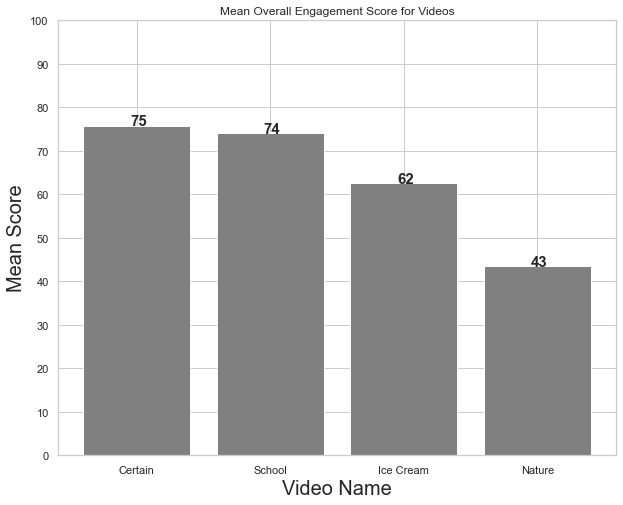

In [3]:
video_mean = {}
sns.set_theme(style="whitegrid", palette="pastel")
for i in range(1,5,1):
    video_mean[i] = questionnaire_data[questionnaire_data.stimulus==i].value.mean()
plt.figure(figsize=(10,8))
bars = plt.bar(x=['Certain','School','Ice Cream','Nature'],height=video_mean.values(),color="grey")

plt.yticks(range(0,101,10))
for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x()+0.35,y_val + .005, int(y_val),fontweight='bold',fontsize=15)
plt.xlabel('Video Name',fontsize=20)
plt.ylabel('Mean Score',fontsize=20)
plt.title("Mean Overall Engagement Score for Videos")
plt.show()


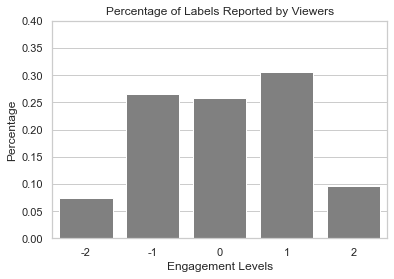

In [4]:
d = observer_data[['annotation_1','annotation_2','annotation_3']]
d = d.apply(pd.value_counts)
d['count'] = d.sum(axis =1)
d['perc'] = d['count'] / d['count'].sum()

sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray'})
sns.set_theme(style="whitegrid", palette="pastel")

sns.barplot(y= d['perc'],x=d.index,color='gray')

plt.xlabel('Engagement Levels')
plt.ylabel('Percentage')
plt.title('Percentage of Labels Reported by Viewers')
plt.yticks(np.arange(0,0.41,0.05));

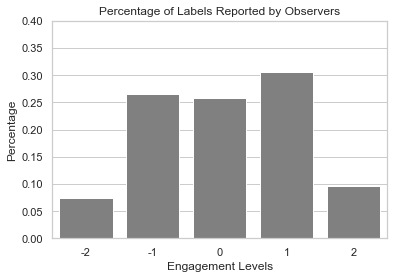

In [5]:
d = observer_data[['annotation_1','annotation_2','annotation_3']]
d = d.apply(pd.value_counts)
d['count'] = d.sum(axis =1)
d['perc'] = d['count'] / d['count'].sum()

sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray'})
sns.set_theme(style="whitegrid", palette="pastel")

sns.barplot(y= d['perc'],x=d.index,color='gray')

plt.xlabel('Engagement Levels')
plt.ylabel('Percentage')
plt.title('Percentage of Labels Reported by Observers')
plt.yticks(np.arange(0,0.41,0.05));

Text(0, 0.5, 'Mean Activation')

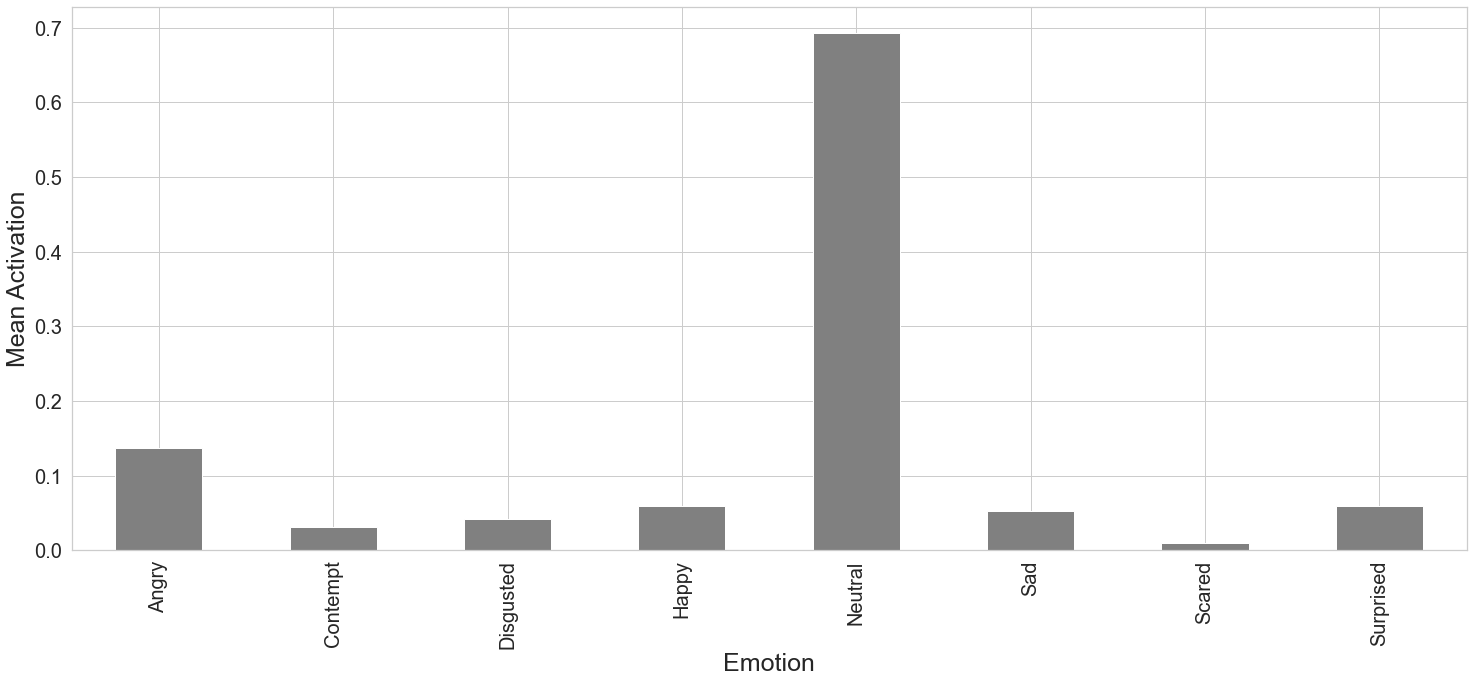

In [6]:
data = data[data.Neutral != '-']

plt.figure(figsize=(25,10))
for i in ['Angry',
       'Contempt', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared',
       'Surprised']:
    data[i] = [float(x) for x in data[i]]

data[['Angry','Contempt', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared','Surprised']].mean().plot(kind='bar',color='gray',fontsize = 20)
plt.xlabel('Emotion',fontsize = 25)
plt.ylabel('Mean Activation',fontsize = 25)

#### 3.2. Rating Agreement Between Viewers and Observers: 

In [7]:
agreement_data = data[data.viewer_engagement == data.observer_report_3].reset_index(drop=True)
print(len(agreement_data) / len(data) * 100)

22.43290981416612


#### 3.3 Viewers’ Selected Action Units:

In [8]:
#plt.figure(figsize=(15,10))
au_activation = {x:[] for x in action_units}
au_activation_e, au_activation_n, au_activation_ne = {x:[] for x in action_units},{x:[] for x in action_units},{x:[] for x in action_units}
for j in action_units:
    for i in data.Observation.unique():
        temp_data = data[data.Observation == i]
        au_activation[j].append(temp_data[j].mean())
        au_activation_e[j].append(temp_data[temp_data.viewer_engagement == 'e'][j].mean())
        au_activation_n[j].append(temp_data[temp_data.viewer_engagement == 'n'][j].mean())
        au_activation_ne[j].append(temp_data[temp_data.viewer_engagement == 'ne'][j].mean())

au_activation = pd.DataFrame(au_activation)
au_activation_e = pd.DataFrame(au_activation_e)
au_activation_n = pd.DataFrame(au_activation_n)
au_activation_ne = pd.DataFrame(au_activation_ne)

k = pd.concat([au_activation,au_activation_e,au_activation_n,au_activation_ne])
au_percentage = {x:[] for x in action_units}
au_percentage_engagement = {x:[] for x in action_units}
percentage = 0.1
for i in action_units:
    au_activation[i] = [float(x) for x in au_activation[i]]
    au_percentage[i].append(len(au_activation[au_activation[i] > percentage]) / len(au_activation) *  100)
    au_percentage[i].append(len(au_activation_e[au_activation_e[i] > percentage]) / len(au_activation_e) *  100)
    au_percentage[i].append(len(au_activation_n[au_activation_n[i] > percentage]) / len(au_activation_n) *  100)
    au_percentage[i].append(len(au_activation_ne[au_activation_ne[i] > percentage]) / len(au_activation_ne) *  100)

mean_data = pd.DataFrame(index=au_percentage.keys(),data=au_percentage.values()).rename(columns={0:'Overall',
1:'Engaged',2:'Neutral',3:'Not Engaged'})
lst = [au_activation,au_activation_e,au_activation_e,au_activation_ne]

# If you want to use Mean values rather than percentages!
mean_data["Overall"] = au_activation.mean()
mean_data["Engaged"] = au_activation_e.mean()
mean_data["Neutral"] = au_activation_n.mean()
mean_data["Not Engaged"] = au_activation_ne.mean()

sns.set_theme(style="whitegrid", palette="pastel")

fig,axes = plt.subplots(2,2,figsize=(15,10),dpi=600)
axes = axes.ravel()
threshold = 0.1
fig.suptitle("Viewer")
for i,k in zip(mean_data.columns,axes):
    above_threshold = np.maximum(mean_data[i] - threshold,0)
    below_threshold = np.minimum(mean_data[i],threshold)

    k.bar([x.split("-")[0].strip().split(" ")[-1] for x in mean_data.index],below_threshold,color="gray")
    k.bar([x.split("-")[0].strip().split(" ")[-1] for x in mean_data.index],above_threshold,color="black",bottom=below_threshold)
    k.set_title(i)
    k.set_ylabel("Mean Activation")
    k.set_xlabel("Action Units")
    k.plot([-0.9, 18.5], [threshold, threshold], "k--")
plt.tight_layout()

In [9]:
selected_action_units = ['Action Unit 02 - Outer Brow Raiser',
 'Action Unit 04 - Brow Lowerer',
 'Action Unit 05 - Upper Lid Raiser',
 'Action Unit 06 - Cheek Raiser',
 'Action Unit 10 - Upper Lip Raiser',
 'Action Unit 15 - Lip Corner Depressor',
 'Action Unit 24 - Lip Pressor ',
 'Action Unit 27 - Mouth Stretch',
]

## Overall with labels Creating simulus dataset!
au_activation = {x:[] for x in action_units}
au_activation_e, au_activation_n, au_activation_ne = {x:[] for x in action_units},{x:[] for x in action_units},{x:[] for x in action_units}
for j in action_units:
    for i in data.Observation.unique():
        temp_data = data[data.Observation == i]
        au_activation[j].append(temp_data[j].mean())
        au_activation_e[j].append(temp_data[temp_data.viewer_engagement == 'e'][j].mean())
        au_activation_n[j].append(temp_data[temp_data.viewer_engagement == 'n'][j].mean())
        au_activation_ne[j].append(temp_data[temp_data.viewer_engagement == 'ne'][j].mean())

au_activation = pd.DataFrame(au_activation)
au_activation_e = pd.DataFrame(au_activation_e)
au_activation_n = pd.DataFrame(au_activation_n)
au_activation_ne = pd.DataFrame(au_activation_ne)

au_actionvation_e_selected = au_activation_e[selected_action_units].rename(columns={x:x.split("-")[0].strip().split(" ")[-1]+"_E" for x in au_activation_e.columns})
au_actionvation_n_selected = au_activation_n[selected_action_units].rename(columns={x:x.split("-")[0].strip().split(" ")[-1]+"_N" for x in au_activation_n.columns})
au_actionvation_ne_selected = au_activation_ne[selected_action_units].rename(columns={x:x.split("-")[0].strip().split(" ")[-1]+"_NE" for x in au_activation_ne.columns})

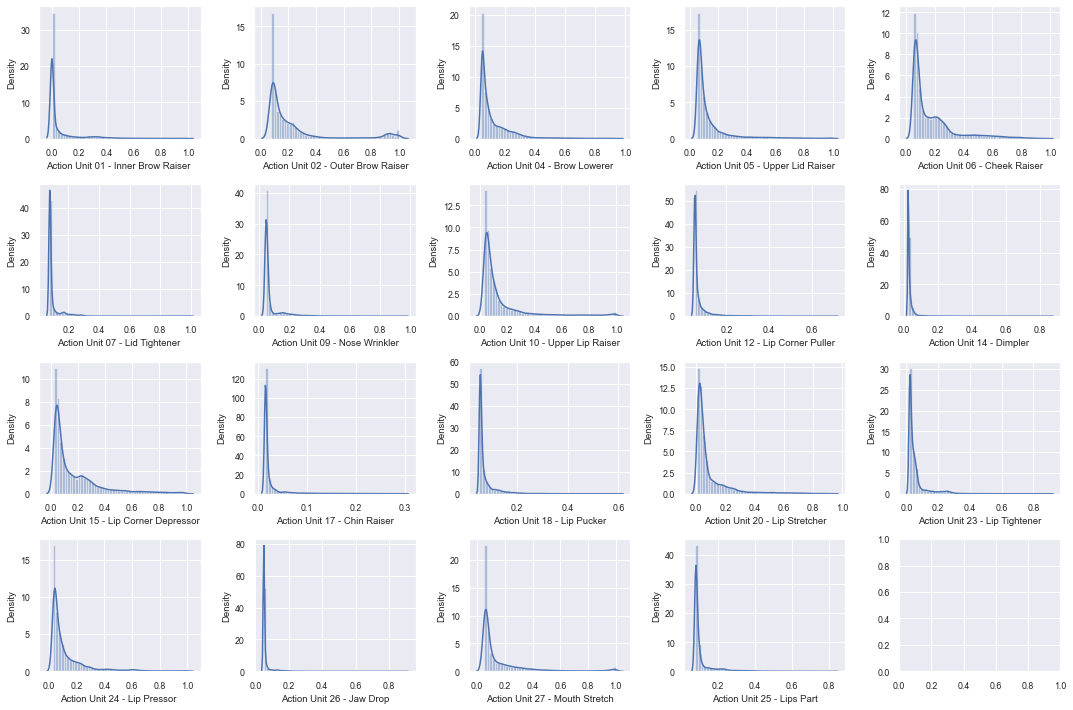

In [28]:
## Distribution plots for all action units
fig, axes = plt.subplots(4,5,figsize=(15,10))
axes = axes.ravel()
for i,ax in zip(action_units,axes):
    sns.distplot(data[i],ax=ax)
plt.tight_layout()

####  3.4 Pitch, Yaw, Roll Data

In [10]:
data["Pitch"] = [float(x) for x in data["Pitch"]]
data["Yaw"] = [float(x) for x in data["Yaw"]]
data["Roll"] = [float(x) for x in data["Roll"]]

head_movement = {"Yaw-E":[data[(data.Observation == x) & (data.viewer_engagement == "e")]["Yaw"].mean() for x in data.Observation.unique()],
"Yaw-N":[data[(data.Observation == x) & (data.viewer_engagement == "n")]["Yaw"].mean() for x in data.Observation.unique()],
"Yaw-NE":[data[(data.Observation == x) & (data.viewer_engagement == "ne")]["Yaw"].mean() for x in data.Observation.unique()],
"Roll-E":[data[(data.Observation == x) & (data.viewer_engagement == "e")]["Roll"].mean() for x in data.Observation.unique()],
"Roll-N":[data[(data.Observation == x) & (data.viewer_engagement == "n")]["Roll"].mean() for x in data.Observation.unique()],
"Roll-Ne":[data[(data.Observation == x) & (data.viewer_engagement == "ne")]["Roll"].mean() for x in data.Observation.unique()],
"Pitch-E":[data[(data.Observation == x) & (data.viewer_engagement == "e")]["Pitch"].mean() for x in data.Observation.unique()],
"Pitch-N":[data[(data.Observation == x) & (data.viewer_engagement == "n")]["Pitch"].mean() for x in data.Observation.unique()],
"Pitch-Ne":[data[(data.Observation == x) & (data.viewer_engagement == "ne")]["Pitch"].mean() for x in data.Observation.unique()]}
head_movement = pd.DataFrame(head_movement)


####  3.7. Electrodermal Activity:

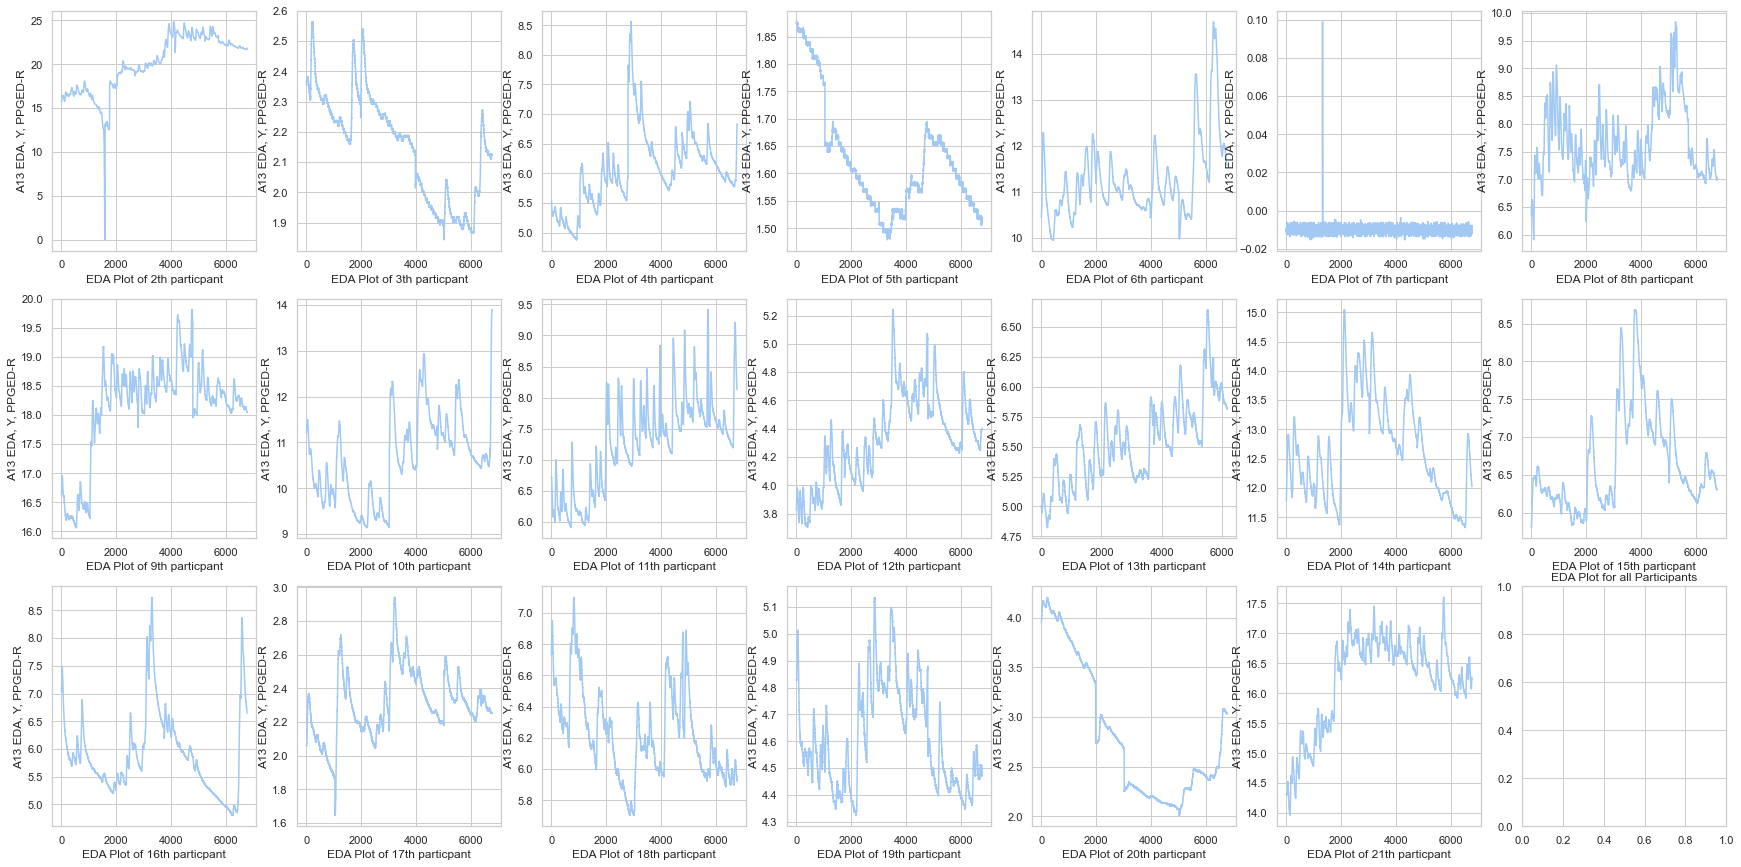

In [12]:
fig, axes = plt.subplots(3,7,figsize=(30,15))
axes = axes.ravel()
for i,j in zip(data.Observation.unique(),axes):
    sns.lineplot(x = [x for x in range(0,len(data[data.Observation == i ]))],y = data[data.Observation == i]["A13 EDA, Y, PPGED-R"],ax=j)
    plt.title("EDA Plot for all Participants")
    j.set_xlabel(f"EDA Plot of {i}th particpant")

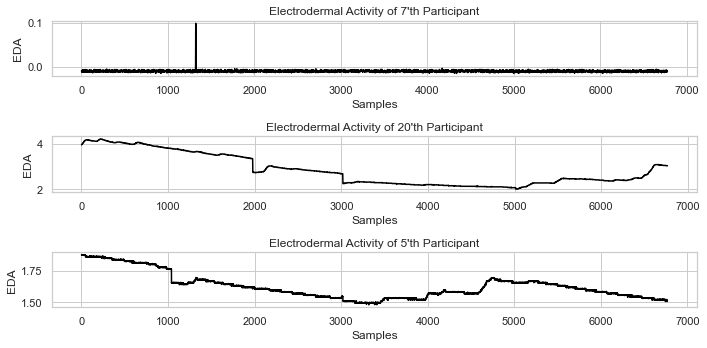

In [13]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
axes = axes.ravel()
for i,j in zip([7,20,5],axes):
    sns.lineplot(x = [x for x in range(0,len(data[data.Observation == i ]))],y = data[data.Observation == i]["A13 EDA, Y, PPGED-R"],ax=j,color="black")
    j.set_xlabel("Samples")
    j.set_ylabel("EDA")
    j.set_title(f"Electrodermal Activity of {i}'th Participant")
plt.tight_layout()


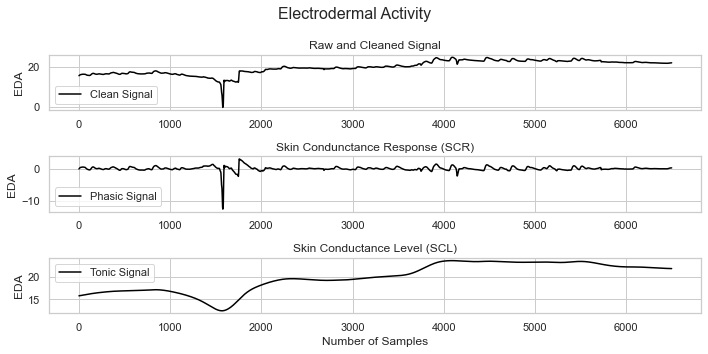

In [14]:
import neurokit2 as nk
temp = []
for i in data.Observation.unique():
    signals, info = nk.eda_process(data[data.Observation == i]["A13 EDA, Y, PPGED-R"], sampling_rate=30)
    temp.append(signals)

temp = pd.concat(temp).reset_index(drop=True)
data = pd.concat([data,temp],axis=1)
eda_data = data[data.Observation !=7]
eda_data = eda_data[eda_data.Observation !=5]
eda_data = eda_data[eda_data.Observation !=20]
eda_data = eda_data.reset_index(drop=True)

sns.set_style("whitegrid")

fig,axes = plt.subplots(3,1,figsize=(20,10))

axes = axes.ravel()
n_samples = 6500
fig.suptitle('Electrodermal Activity', fontsize=16)
eda_data[["EDA_Clean"]].iloc[:n_samples].plot(figsize=(10,5),ax=axes[0],color="black")
axes[0].set_title("Raw and Cleaned Signal")
axes[2].set_xlabel("Number of Samples")
eda_data[["EDA_Phasic"]].iloc[:n_samples].plot(figsize=(10,5),ax=axes[1],color="black")
axes[1].set_title("Skin Condunctance Response (SCR)")
eda_data[["EDA_Tonic"]].iloc[:n_samples].plot(figsize=(10,5),ax=axes[2],color="black")
axes[2].set_title("Skin Conductance Level (SCL)")
axes[0].legend(["Clean Signal"])
axes[1].legend(["Phasic Signal"])
axes[2].legend(["Tonic Signal"])
axes[0].set_ylabel("EDA")
axes[1].set_ylabel("EDA")
axes[2].set_ylabel("EDA")

plt.tight_layout()


####  3.8 Observers’ Selected Action Units

In [ ]:
## Overall without labels

au_activation = {x:[] for x in action_units}
au_activation_e, au_activation_n, au_activation_ne = {x:[] for x in action_units},{x:[] for x in action_units},{x:[] for x in action_units}
for j in action_units:
    for i in data.Observation.unique():
        temp_data = data[data.Observation == i]
        au_activation[j].append(temp_data[j].mean())
        au_activation_e[j].append(temp_data[temp_data.observer_report_3 == 'e'][j].mean())
        au_activation_n[j].append(temp_data[temp_data.observer_report_3 == 'n'][j].mean())
        au_activation_ne[j].append(temp_data[temp_data.observer_report_3 == 'ne'][j].mean())

au_activation = pd.DataFrame(au_activation)
au_activation_e = pd.DataFrame(au_activation_e)
au_activation_n = pd.DataFrame(au_activation_n)
au_activation_ne = pd.DataFrame(au_activation_ne)

au_percentage = {x:[] for x in action_units}
#au_percentage_engagement = {{x:[] for x in action_units}}
percentage = 0.1
for i in action_units:
    au_activation[i] = [float(x) for x in au_activation[i]]
    au_percentage[i].append(len(au_activation[au_activation[i] > percentage]) / len(au_activation) *  100)
    au_percentage[i].append(len(au_activation_e[au_activation_e[i] > percentage]) / len(au_activation_e) *  100)
    au_percentage[i].append(len(au_activation_n[au_activation_n[i] > percentage]) / len(au_activation_n) *  100)
    au_percentage[i].append(len(au_activation_ne[au_activation_ne[i] > percentage]) / len(au_activation_ne) *  100)

mean_data = pd.DataFrame(index=au_percentage.keys(),data=au_percentage.values()).rename(columns={0:'Overall',
1:'Engaged',2:'Neutral',3:'Not Engaged'})
lst = [au_activation,au_activation_e,au_activation_e,au_activation_ne]
# If you want to use Mean values rather than percentages!
mean_data["Overall"] = au_activation.mean()
mean_data["Engaged"] = au_activation_e.mean()
mean_data["Neutral"] = au_activation_n.mean()
mean_data["Not Engaged"] = au_activation_ne.mean()

#plt.figure(figsize=(15,10))
fig,axes = plt.subplots(2,2,figsize=(20,15))
axes = axes.ravel()
threshold = 0.1
fig.suptitle("Observer")
for i,k in zip(mean_data.columns,axes):
    above_threshold = np.maximum(mean_data[i] - threshold,0)
    below_threshold = np.minimum(mean_data[i],threshold)
    k.bar([x.split("-")[0].strip().split(" ")[-1] for x in mean_data.index],below_threshold,color="grey")
    k.bar([x.split("-")[0].strip().split(" ")[-1] for x in mean_data.index],above_threshold,color="black",bottom=below_threshold)
    k.set_title(i)
    k.set_ylabel("Mean Activation")
    k.set_xlabel("Action Units")
    k.plot([-0.9, 18.5], [threshold, threshold], "k--")


####  3.9 Engagement Recognition using Action Units: 

In [15]:
action_units = ['Action Unit 01 - Inner Brow Raiser ',
 'Action Unit 02 - Outer Brow Raiser',
 'Action Unit 04 - Brow Lowerer',
 'Action Unit 05 - Upper Lid Raiser',
 'Action Unit 06 - Cheek Raiser',
 'Action Unit 07 - Lid Tightener ',
 'Action Unit 09 - Nose Wrinkler',
 'Action Unit 10 - Upper Lip Raiser',
 'Action Unit 12 - Lip Corner Puller',
 'Action Unit 14 - Dimpler ',
 'Action Unit 15 - Lip Corner Depressor',
 'Action Unit 17 - Chin Raiser',
 'Action Unit 18 - Lip Pucker',
 'Action Unit 20 - Lip Stretcher',
 'Action Unit 23 - Lip Tightener',
 'Action Unit 24 - Lip Pressor ',
 'Action Unit 26 - Jaw Drop',
 'Action Unit 27 - Mouth Stretch']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
tree = DecisionTreeClassifier(max_depth= 7,criterion='entropy')
svc = LinearSVC()
log_reg = LogisticRegression()
tree_participant = DecisionTreeClassifier(max_depth= 20,criterion='entropy')
svc_participant = LinearSVC()
log_reg_participant = LogisticRegression()
data["dummy_viewer"]  = [(1 if x == "e" else (0 if x == "n" else -1))for x in data.viewer_engagement]
X = data[action_units]
y = data.dummy_viewer


#####  First Method:

In [ ]:
# Decision Tree
accuracy = {"f1":[],"accuracy":[],"auc":[]}
tree = DecisionTreeClassifier(criterion='entropy')
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
    tree.fit(X_train,y_train)
    accuracy["accuracy"].append(tree.score(X_test,y_test))
    accuracy["auc"].append(roc_auc_score(y_true=y_test,y_score=tree.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy["f1"].append(f1_score(tree.predict(X_test),y_test,average="weighted",))

fig = plt.figure(figsize=(10,6))
class_names = [str(x) for x in list(y.unique())]
class_names = ["Neutral","Engaged","Not Engaged"]
_ = plot_tree(tree,class_names= class_names,filled=True,feature_names=[x.split("-")[0] for x in action_units],fontsize=10,rounded=True,max_depth=2)


In [ ]:
# Linear SVM
accuracy_svc = {"f1":[],"accuracy":[],"auc":[]}
svc = LinearSVC()
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
    clf = CalibratedClassifierCV(svc) 
    clf.fit(X_train,y_train)
    accuracy_svc["accuracy"].append(clf.score(X_test,y_test))
    accuracy_svc["auc"].append(roc_auc_score(y_true=y_test,y_score=clf.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy_svc["f1"].append(f1_score(clf.predict(X_test),y_test,average="weighted"))

In [ ]:
# Logistic Regression
import warnings
warnings.filterwarnings("ignore")
accuracy_logictic = {"f1":[],"accuracy":[],"auc":[]}
log_reg = LogisticRegression(multi_class="multinomial")
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
    log_reg.fit(X_train,y_train)
    accuracy_logictic["accuracy"].append(log_reg.score(X_test,y_test))
    accuracy_logictic["auc"].append(roc_auc_score(y_true=y_test,y_score=log_reg.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy_logictic["f1"].append(f1_score(log_reg.predict(X_test),y_test,average="weighted"))

#####  Second Method:

In [ ]:
# Decision Tree
accuracy_participant_tree =  {"f1":[],"accuracy":[],"auc":[]}
for i in range(10):
    test_sample = random.sample([x for x in range(1,22,1)], k = 6)
    X_train = data[~data.Observation.isin(test_sample)][action_units]
    y_train = data[~data.Observation.isin(test_sample)].dummy_viewer
    X_test = data[data.Observation.isin(test_sample)][action_units]
    y_test = data[data.Observation.isin(test_sample)].dummy_viewer
    tree_participant.fit(X_train,y_train)
    accuracy_participant_tree["accuracy"].append(tree_participant.score(X_test,y_test))
    accuracy_participant_tree["auc"].append(roc_auc_score(y_true=y_test,y_score=tree.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy_participant_tree["f1"].append(f1_score(tree_participant.predict(X_test),y_test,average="weighted"))

In [ ]:
# Linear SVM
accuracy_participant_svc =  {"f1":[],"accuracy":[],"auc":[]}
for i in range(10):
    test_sample = random.sample([x for x in range(1,22,1)], k = 6)
    X_train = data[~data.Observation.isin(test_sample)][action_units]
    y_train = data[~data.Observation.isin(test_sample)].dummy_viewer
    X_test = data[data.Observation.isin(test_sample)][action_units]
    y_test = data[data.Observation.isin(test_sample)].dummy_viewer
    clf_participant = CalibratedClassifierCV(svc_participant) 
    clf_participant.fit(X_train,y_train)
    accuracy_participant_svc["accuracy"].append(clf_participant.score(X_test,y_test))
    accuracy_participant_svc["auc"].append(roc_auc_score(y_true=y_test,y_score=clf.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy_participant_svc["f1"].append(f1_score(clf_participant.predict(X_test),y_test,average="weighted"))

In [ ]:
# Logistic Regression
import warnings
warnings.filterwarnings("ignore")
accuracy_participant_log =  {"f1":[],"accuracy":[],"auc":[]}
for i in range(10):
    test_sample = random.sample([x for x in range(1,22,1)], k = 6)
    X_train = data[~data.Observation.isin(test_sample)][action_units]
    y_train = data[~data.Observation.isin(test_sample)].dummy_viewer
    X_test = data[data.Observation.isin(test_sample)][action_units]
    y_test = data[data.Observation.isin(test_sample)].dummy_viewer
    log_reg_participant.fit(X_train,y_train)
    accuracy_participant_log["accuracy"].append(accuracy_score(log_reg_participant.predict(X_test),y_test))
    accuracy_participant_log["auc"].append(roc_auc_score(y_true=y_test,y_score=log_reg.predict_proba(X_test),multi_class="ovo",average="macro"))
    accuracy_participant_log["f1"].append(f1_score(log_reg_participant.predict(X_test),y_test,average="weighted"))

In [ ]:
## Visualization of Decision Tree

fig = plt.figure(figsize=(10,6))
class_names = [str(x) for x in list(y.unique())]
class_names = ["Not Engaged","Neutral","Engaged"]
_ = plot_tree(tree,class_names= class_names,filled=True,feature_names=[x.split("-")[0] for x in action_units],fontsize=10,rounded=True,max_depth=2)
plt.savefig('filename.png', dpi=300)


In [ ]:
# Visualization of Confusion Matrices for First Method
plt.rcParams['figure.dpi'] = 500
fig,axes = plt.subplots(1,3,figsize=(20,5))
axes = axes.ravel()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.4)
                
for i,ax in zip([tree_participant,log_reg_participant,clf_participant],axes):
    cm = confusion_matrix(i.predict(X_test),y_test)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if str(i).startswith("DecisionTree"):
        ax.set_title("Decision Tree",fontname="Times New Roman",fontweight="bold")
    if str(i).startswith("Logistic"):
        ax.set_title("Multinomial Logistic Regression",fontname="Times New Roman",fontweight="bold")
    if str(i).startswith("CalibratedClassifierCV"):
        ax.set_title("Linear SVM",fontname="Times New Roman",fontweight="bold")
    sns.heatmap(cmn, annot=True, fmt=".2%", xticklabels=["Not Engaged","Neutral","Engaged"], yticklabels=["Not Engaged","Neutral","Engaged"],vmin=0,vmax=1,ax=ax,cmap="gray",linewidths=2,annot_kws={"fontsize":15})
    ax.set_xlabel("Predicted",fontsize=15)
    ax.set_ylabel("Actual",fontsize=15)
plt.tight_layout()

In [ ]:
# Visualization of Confusion Matrices for Second Method
plt.rcParams['figure.dpi'] = 500
fig,axes = plt.subplots(1,3,figsize=(20,5))
axes = axes.ravel()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.4)
                
for i,ax in zip([tree_participant,log_reg_participant,clf_participant],axes):
    cm = confusion_matrix(i.predict(X_test),y_test)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if str(i).startswith("DecisionTree"):
        ax.set_title("Decision Tree",fontname="Times New Roman",fontweight="bold")
    if str(i).startswith("Logistic"):
        ax.set_title("Multinomial Logistic Regression",fontname="Times New Roman",fontweight="bold")
    if str(i).startswith("CalibratedClassifierCV"):
        cmn[0,:] = [0,0,0]
        ax.set_title("Linear SVM",fontname="Times New Roman",fontweight="bold")
    sns.heatmap(cmn, annot=True, fmt=".2%", xticklabels=["Not Engaged","Neutral","Engaged"], yticklabels=["Not Engaged","Neutral","Engaged"],vmin=0,vmax=1,ax=ax,cmap="gray",linewidths=2,annot_kws={"fontsize":15})
    ax.set_xlabel("Predicted",fontsize=15)
    ax.set_ylabel("Actual",fontsize=15)
plt.tight_layout()

####  Appendix E

<AxesSubplot:>

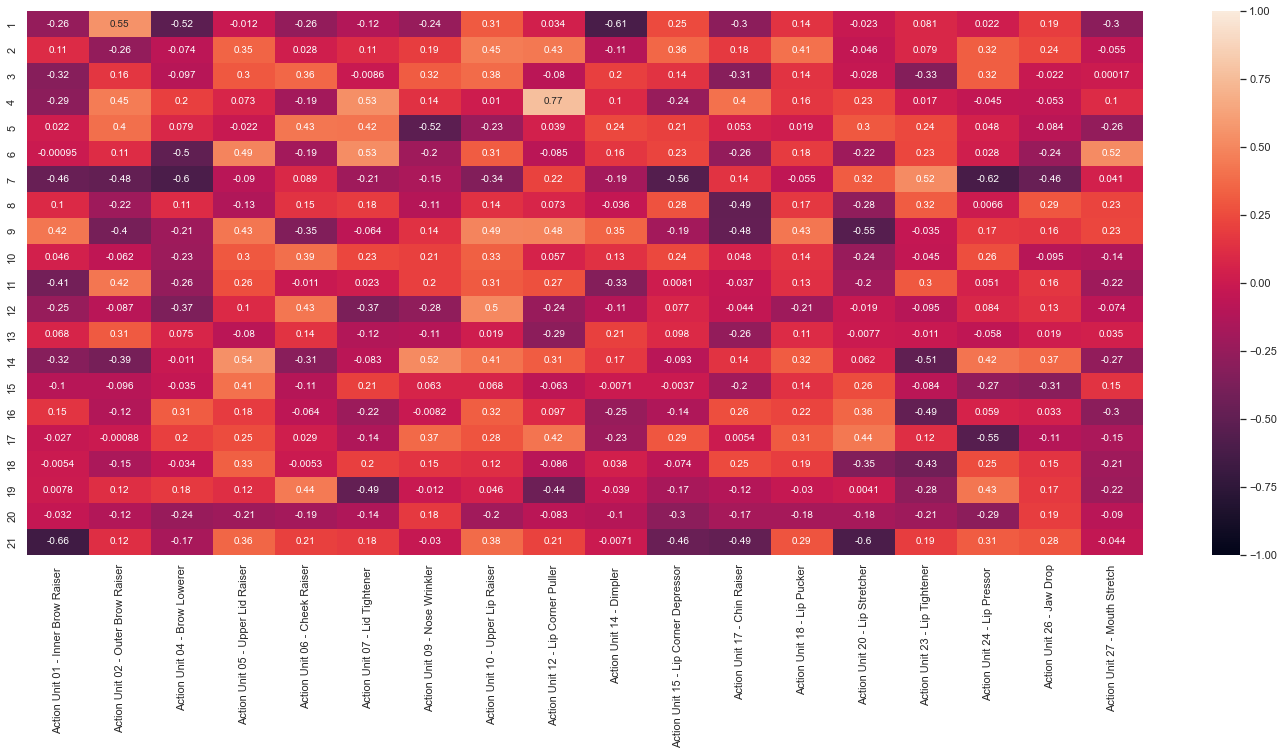

In [21]:
temp = {}
for i in data.Observation.unique():
    temp[i] = data[data.Observation == i][correlation].corr()["Behavior"]
temp = pd.DataFrame(temp).T.drop(["Behavior"],axis=1)
plt.figure(figsize=(25,10))
sns.heatmap(temp,annot=True,annot_kws={"size":10},fmt=".2",vmin=-1,vmax=1)

####  Confusion Matrix for Observers' and Viewers' Report

Accuracy is 0.32324968721709674


<AxesSubplot:>

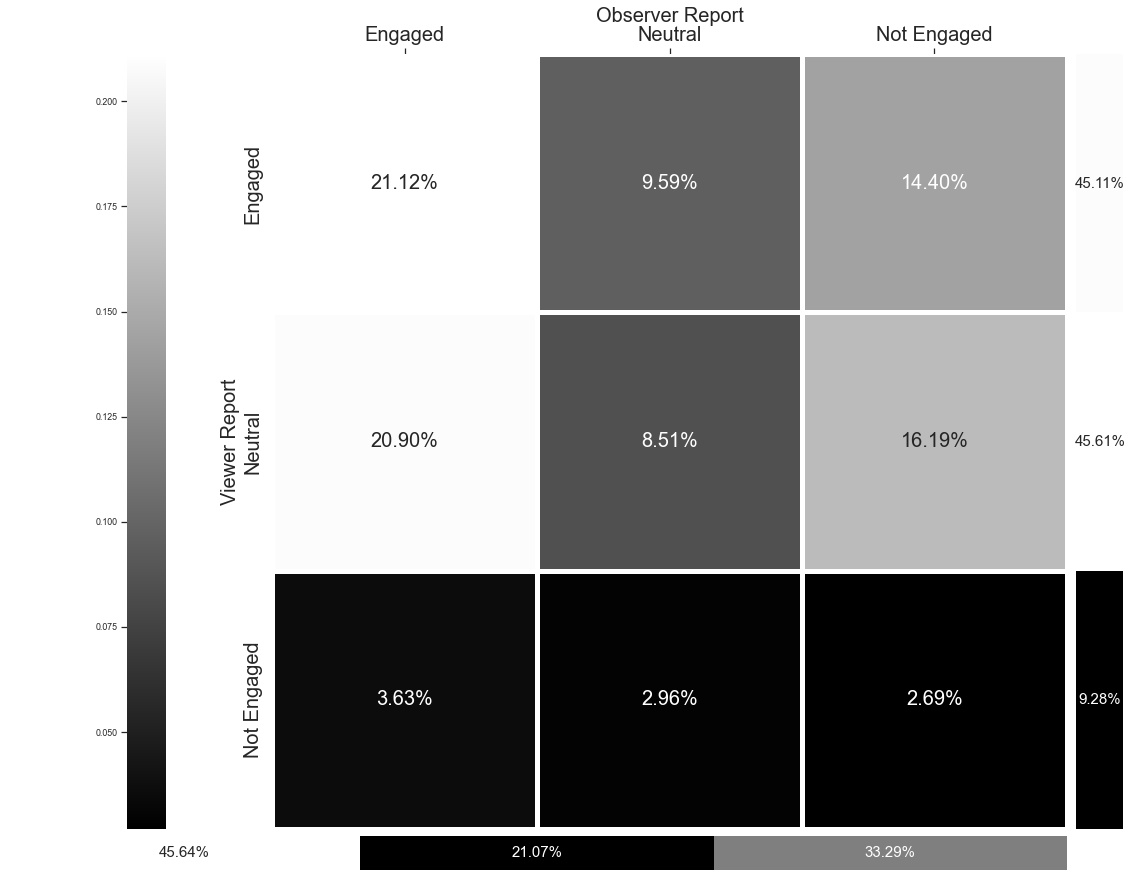

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score


temp = data[data.observer_report_3 != "None"]
temp = temp[temp.observer_report_3 != "Nope"]
temp = temp.reset_index(drop=True)

confusion_matrix(temp.viewer_engagement,temp.observer_report_3)

fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)
sns.set(font_scale=0.8)
cm = confusion_matrix(temp.viewer_engagement,temp.observer_report_3)
sns.heatmap(cm/np.sum(cm),annot=True,fmt=".2%",linewidths=5,
xticklabels=["Engaged","Neutral","Not Engaged"],yticklabels=["Engaged","Neutral","Not Engaged"],ax=ax1,cbar=True,cmap="gray",annot_kws={"size":20},
cbar_kws = dict(use_gridspec=False,location="left"))
ax1.set_xlabel("Observer Report",fontsize=20,)
ax1.set_ylabel("Viewer Report",fontsize=20)
ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
ax1.tick_params(labelsize=20)
conf = confusion_matrix(temp.viewer_engagement,temp.observer_report_3)
print("Accuracy is", accuracy_score(temp.viewer_engagement,temp.observer_report_3))
temp = pd.DataFrame(cm/np.sum(cm),columns=["Engaged","Neutral","Not Engaged"],
index=["Engaged","Neutral","Not Engaged"])
sns.heatmap((pd.DataFrame(temp.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="gray", cbar=False, xticklabels=False, yticklabels=False,fmt=".2%",annot_kws={"size":15})
sns.heatmap(pd.DataFrame(temp.sum(axis=1)), ax=ax3,  annot=True, cmap="gray", cbar=False, xticklabels=False, yticklabels=False,fmt=".2%",annot_kws={"size":15})
